In [14]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

warnings.filterwarnings('ignore')


基本変数定義

In [15]:
sampling_flg=0 #サンプリング有無をコントロール
submit_flg=1 #保存するかをコントロール（サンプリングしない時のみ）

SEED=12345
sample_num=10000
fold_num=5

#train関連
train_dir='../../01_input/train.csv'
#train_feature_dir_1='../../02_feature/119_train_NegPosCount.csv'
train_feature_dir_2='../../02_feature/114_train_means.csv'
#train_feature_dir_3='../../02_feature/116_train_quantile.csv'
#train_feature_dir_4='../../02_feature/102_train_kmeans.csv'

train_drop_col=['ID_code', 'target']
train_label='target'

#test関連
test_dir='../../01_input/test.csv'
#test_feature_dir_1='../../02_feature/119_test_NegPosCount.csv'
test_feature_dir_2='../../02_feature/114_test_means.csv'
#test_feature_dir_3='../../02_feature/116_test_quantile.csv'
#test_feature_dir_4='../../02_feature/102_test_kmeans.csv'

test_drop_col=['ID_code']

#結果ファイル関連　nameは自分の名前に変更する
train_preds_dir='../../03_predict_train/oka_245_LightGBM_NegPosCount_train.csv'
test_preds_dir='../../04_predict_test/oka_245_LightGBM_NegPosCount_submission.csv'
save_col_name='oof_xgb'

sample_submission_dir='../../01_input/sample_submission.csv'
submission_target_col_name='target'
submission_id_col_name='ID_code'

前処理

In [16]:
#ロード
train_df=pd.read_csv(train_dir)
test_df=pd.read_csv(test_dir)
#train_feature_df_1=pd.read_csv(train_feature_dir_1)
#test_feature_df_1=pd.read_csv(test_feature_dir_1)
train_feature_df_2=pd.read_csv(train_feature_dir_2)
test_feature_df_2=pd.read_csv(test_feature_dir_2)
#train_feature_df_3=pd.read_csv(train_feature_dir_3)
#test_feature_df_3=pd.read_csv(test_feature_dir_3)
#train_feature_df_4=pd.read_csv(train_feature_dir_4)
#test_feature_df_4=pd.read_csv(test_feature_dir_4)

#train_df=pd.concat([train_df,train_feature_df_1],axis=1)
#test_df=pd.concat([test_df,test_feature_df_1],axis=1)
train_df=pd.concat([train_df,train_feature_df_2],axis=1)
test_df=pd.concat([test_df,test_feature_df_2],axis=1)
#train_df=pd.concat([train_df,train_feature_df_3],axis=1)
#test_df=pd.concat([test_df,test_feature_df_3],axis=1)
#train_df=pd.concat([train_df,train_feature_df_4],axis=1)
#test_df=pd.concat([test_df,test_feature_df_4],axis=1)

In [17]:
pd.set_option('display.max_columns', 1000)
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,mean_0,negCount_0,mean_1,negCount_1,mean_2,negCount_2,mean_3,negCount_3,mean_4,negCount_4,mean_5,negCount_5,mean_6,negCount_6,mean_7,negCount_7,mean_8,negCount_8,mean_9,negCount_9,mean_10,negCount_10,mean_11,negCount_11,mean_12,negCount_12,mean_13,negCount_13,mean_14,negCount_14,mean_15,negCount_15,mean_16,negCount_16,mean_17,negCount_17,mean_18,negCount_18,mean_19,negCount_19,mean_20,negCount_20,mean_21,negCount_21,mean_22,negCount_22,mean_23,negCount_23,mean_24,negCount_24,mean_25,negCount_25,mean_26,negCount_26,mean_27,negCount_27,mean_28,negCount_28,mean_29,negCount_29,mean_30,negCount_30,mean_31,negCount_31,mean_32,negCount_32,mean_33,negCount_33,mean_34,negCount_34,mean_35,negCount_35,mean_36,negCount_36,mean_37,negCount_37,mean_38,negCount_38,mean_39,negCount_39,mean_40,negCount_40,mean_41,negCount_41,mean_42,negCount_42,mean_43,negCount_43,mean_44,negCount_44,mean_45,negCount_45,mean_46,negCount_46,mean_47,negCount_47,mean_48,negCount_48,mean_49,negCount_49,mean_50,negCount_50,mean_51,negCount_51,mean_52,negCount_52
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857

In [18]:
#サンプリング
if sampling_flg ==1:
    train_df=train_df.sample(n=sample_num,random_state=SEED)
    test_df=test_df.sample(n=sample_num,random_state=SEED)

In [19]:
#x,y作成
x_train=train_df.drop(train_drop_col,axis=1)
y_train=train_df[train_label]
x_test=test_df.drop(test_drop_col,axis=1)

In [21]:
for i in x_train.columns:
    if 'neg' in i:
        print(i)
        x_train=x_train.drop(i,axis=1)
        x_test=x_test.drop(i,axis=1)

negCount_0
negCount_1
negCount_2
negCount_3
negCount_4
negCount_5
negCount_6
negCount_7
negCount_8
negCount_9
negCount_10
negCount_11
negCount_12
negCount_13
negCount_14
negCount_15
negCount_16
negCount_17
negCount_18
negCount_19
negCount_20
negCount_21
negCount_22
negCount_23
negCount_24
negCount_25
negCount_26
negCount_27
negCount_28
negCount_29
negCount_30
negCount_31
negCount_32
negCount_33
negCount_34
negCount_35
negCount_36
negCount_37
negCount_38
negCount_39
negCount_40
negCount_41
negCount_42
negCount_43
negCount_44
negCount_45
negCount_46
negCount_47
negCount_48
negCount_49
negCount_50
negCount_51
negCount_52


モデル実行

In [22]:
#model_param
param = {
    "objective" : "binary", 
    "boost":"gbdt",
    "metric":"auc",
    "boost_from_average":"false",
    "num_threads":28,
    "learning_rate" : 0.01,
    "num_leaves" : 13,
    "max_depth":-1,
    "tree_learner" : "serial",
    "feature_fraction" : 0.05,
    "bagging_freq" : 5,
    "bagging_fraction" : 0.2,
    "min_data_in_leaf" : 80,
    "min_sum_hessian_in_leaf" : 10.0,
    "verbosity" : 1,
    'seed': 44000,
    }

In [23]:
folds = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=SEED)
oof_preds = np.zeros((len(x_train), 1))
test_preds = np.zeros((len(x_test), 1))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("\n")
    print("Fold {}".format(fold_))
    trn_x,trn_y = x_train.iloc[trn_idx], y_train.iloc[trn_idx]
    val_x,val_y = x_train.iloc[val_idx], y_train.iloc[val_idx]
    trn_data = lgb.Dataset(trn_x,trn_y)
    val_data = lgb.Dataset(val_x,val_y)
    
    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    val_pred = clf.predict(val_x, num_iteration=clf.best_iteration)
    test_pred = clf.predict(x_test, num_iteration=clf.best_iteration)
    
    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    #print("val = {}".format(val_pred)
    oof_preds[val_idx, :] = val_pred.reshape((-1, 1))
    test_preds += test_pred.reshape((-1, 1))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = x_train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    
test_preds /= fold_num
roc_score = roc_auc_score(y_train, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))



Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.89645	valid_1's auc: 0.878512
[2000]	training's auc: 0.910758	valid_1's auc: 0.888816
[3000]	training's auc: 0.919394	valid_1's auc: 0.892727
[4000]	training's auc: 0.925926	valid_1's auc: 0.894996
[5000]	training's auc: 0.931354	valid_1's auc: 0.895994
[6000]	training's auc: 0.936273	valid_1's auc: 0.896631
[7000]	training's auc: 0.940643	valid_1's auc: 0.897017
[8000]	training's auc: 0.944831	valid_1's auc: 0.897271
[9000]	training's auc: 0.948792	valid_1's auc: 0.897397
[10000]	training's auc: 0.952445	valid_1's auc: 0.897353
[11000]	training's auc: 0.956032	valid_1's auc: 0.897298
[12000]	training's auc: 0.959333	valid_1's auc: 0.897221
Early stopping, best iteration is:
[9032]	training's auc: 0.948902	valid_1's auc: 0.897433
AUC = 0.8974327177375677


Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.897017	valid_1's auc: 0.878238
[2000]	t

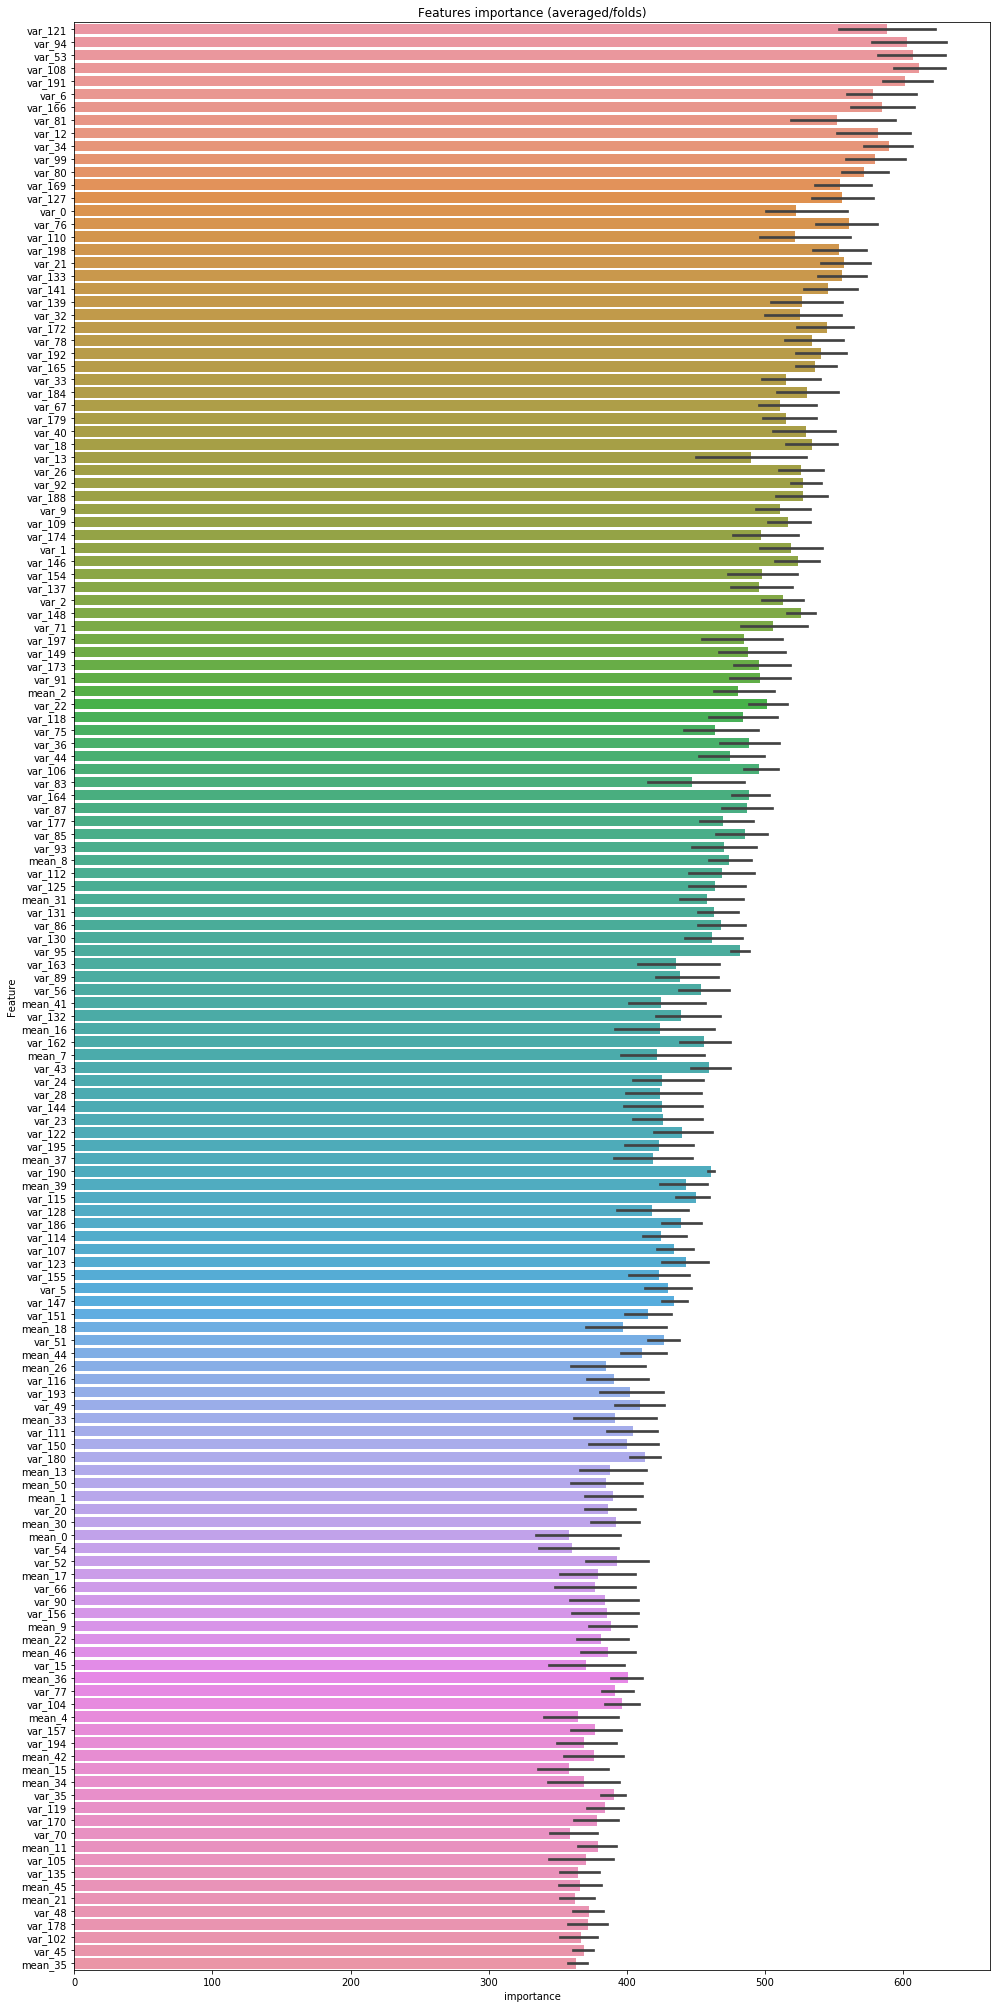

In [24]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('../../04_predict_test/241_FI.png')

In [25]:
#結果保存
if (submit_flg ==1 and sampling_flg==0):
    series_oof_preds = pd.Series(data=oof_preds[:,0], name=save_col_name, dtype='float')
    series_oof_preds.to_csv(train_preds_dir,header=True, index=False)

    sample = pd.read_csv(sample_submission_dir)
    sample.target = test_preds[:,0].astype(float)
    sample.ID_code = test_df['ID_code']
    sample.to_csv(test_preds_dir, index=False)
    